In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
import time
import torch
import torchvision
import csgm
import dcgan
import skimage
import anchor_image
import image_utils
import svgd

In [2]:
mnist_test = torchvision.datasets.MNIST('./', train=False, transform=lambda x: np.array(x)/255.,
                                   target_transform=None, download=True)

In [3]:
dataload = torch.utils.data.DataLoader(mnist_test,batch_size = 32)

### Load Classification Model

In [4]:
net = dcgan.Net()
net.load_state_dict(torch.load('mnist_cnn.pt'))

In [5]:
def predict_fn(images):
    try:
        images = torch.from_numpy(images).type(torch.FloatTensor)
    except:
        pass
    return net(images.view(images.shape[0],1,28,28)).data.numpy()

### Load GAN

In [6]:
g = dcgan.load_generator().cuda()

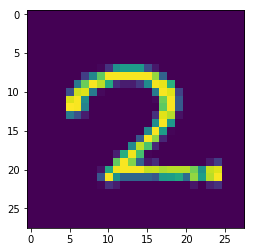

In [7]:
image = mnist_test[77][0]
plt.imshow(image)

In [8]:
segments = image_utils.create_segments(image, kernel_size=2, max_dist=10, ratio=0.2)

In [9]:
exp_ = {}
# exp_['feature']=[i[0] for i in exp]
exp_['feature'] = [5,3]
_,mask = image_utils.create_mask(image,segments,exp_)

In [10]:
target = mask*((image-0.5)*2)

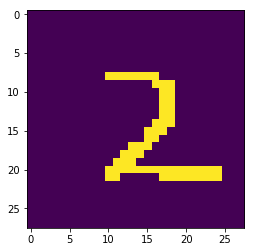

In [11]:
plt.imshow(mask)

### SVGD Testing

In [12]:
G = dcgan.ProbGenerator(g,torch.FloatTensor(mask),torch.FloatTensor(target))

In [149]:
n_particles = 100

In [151]:
X_init = (3 * torch.randn(n_particles, 100)).cuda()
X_init.shape

torch.Size([100, 100])

In [152]:
X = X_init.clone()
stein = svgd.SVGD(G,svgd.RBF(),torch.optim.Adam([X],lr=1e-1))

In [153]:
stein.train(X,1000)

tensor([[  5.2233,  -3.9373, -10.0896,  ...,  10.3737,  13.2836,  16.4421],
        [  6.5379,  -1.3124,  -7.3050,  ...,  -7.6927,   3.2395,   2.2266],
        [ -4.1726,  -9.6702,   7.2913,  ...,   8.9048,   5.7498, -14.2604],
        ...,
        [  9.4998,  -0.1471,  13.3996,  ..., -23.9083,  -1.7049, -22.5629],
        [  5.7864,  -7.6189,   5.6249,  ...,  -2.1509,   5.1269,   7.3969],
        [  2.0862,  12.0531,   1.1533,  ...,  11.3783,   2.2966,   1.3747]],
       device='cuda:0')

### View Results

In [71]:
sample = G(X[3].view(-1,100,1,1)).detach().cpu().numpy().squeeze()

In [72]:
p = G.log_prob(X).exp().detach().cpu().numpy()

(array([894.,  64.,  25.,  13.,   1.,   2.,   0.,   0.,   0.,   1.]),
 array([0.        , 0.00405051, 0.00810102, 0.01215153, 0.01620204,
        0.02025255, 0.02430306, 0.02835358, 0.03240409, 0.0364546 ,
        0.04050511]),
 <a list of 10 Patch objects>)

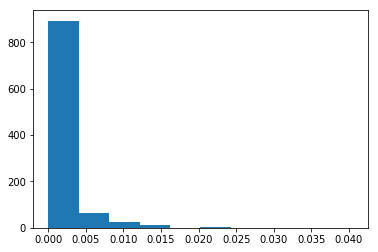

In [73]:
plt.hist(p)

In [94]:
sample = G(X[9].view(-1,100,1,1)).detach().cpu().numpy().squeeze()

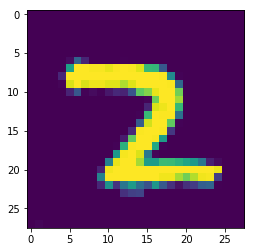

In [95]:
plt.imshow(sample)

## Trying to Visualize points?

In [96]:
from sklearn.decomposition import PCA

In [97]:
model = PCA(2)

In [154]:
x = X.detach().cpu().numpy()

In [155]:
hm = model.fit_transform(x)

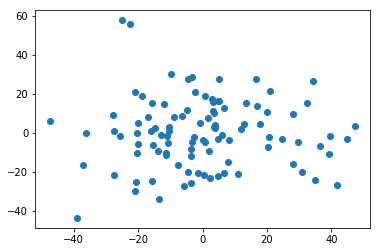

In [156]:
plt.scatter(hm[:,0],hm[:,1])

In [157]:
hm2 = model.fit_transform(X_init.detach().cpu().numpy())

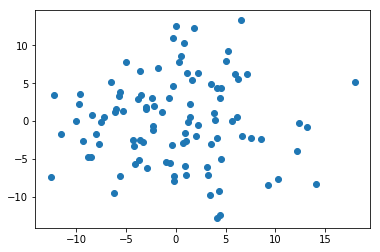

In [158]:
plt.scatter(hm2[:,0],hm2[:,1])

## KDE Sampling? (WIP)

In [103]:
from sklearn.neighbors.kde import KernelDensity
import numpy as np

In [104]:
class RBF(torch.nn.Module):
  def __init__(self, sigma=None):
    super(RBF, self).__init__()

    self.sigma = sigma
    

  def forward(self, X, Y):
    XX = X.matmul(X.t())
    XY = X.matmul(Y.t())
    YY = Y.matmul(Y.t())

    dnorm2 = -2 * XY + XX.diag().unsqueeze(1) + YY.diag().unsqueeze(0)
#     dnorm2 = self.pairwise_distances(X,Y)

    # Apply the median heuristic (PyTorch does not give true median)
    if self.sigma is None:
      np_dnorm2 = dnorm2.detach().cpu().numpy()
      h = np.median(np_dnorm2) / (2 * np.log(X.size(0) + 1))
      sigma = np.sqrt(h).item()
    else:
      sigma = self.sigma

    gamma = 1.0 / (1e-8 + 2 * sigma ** 2)
    K_XY = (-gamma * dnorm2).exp()

    return h,K_XY

In [105]:
RBF()(X,X.detach())

(178.56486850068117,
 tensor([[1.0000, 0.0006, 0.0009,  ..., 0.0012, 0.0009, 0.0002],
         [0.0006, 1.0000, 0.0006,  ..., 0.0006, 0.0014, 0.0004],
         [0.0009, 0.0006, 1.0000,  ..., 0.0009, 0.0026, 0.0005],
         ...,
         [0.0012, 0.0006, 0.0009,  ..., 1.0000, 0.0017, 0.0013],
         [0.0009, 0.0014, 0.0026,  ..., 0.0017, 1.0000, 0.0023],
         [0.0002, 0.0004, 0.0005,  ..., 0.0013, 0.0023, 1.0000]],
        device='cuda:0'))

In [213]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(x)

In [228]:
new_ = kde.sample(100)
sample = G(torch.FloatTensor(new_.reshape(-1,100,1,1)).cuda()).detach().cpu().numpy().squeeze()

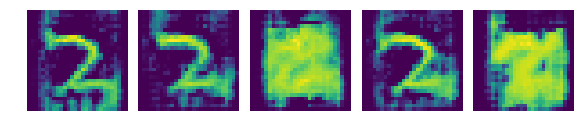

In [229]:
plt.figure(figsize=(10,10))
ax = [plt.subplot(5,5,i+1) for i in range(5)]
plt.subplots_adjust(wspace=0, hspace=0.1);
[ax[i].set_axis_off() for i in range(5)]
for i in range(5):
    ax[i].imshow(sample[i])